In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flax optax jetnet
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [1]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step
from datasets import load_data
from jetnet.datasets import JetNet, TopTagging

EPS = 1e-7


%load_ext autoreload
%autoreload 2

In [2]:
# run_name = "cool-thunder-19"  # wandb run name
run_name = "apple-cake-44"  # wandb run name

In [3]:
config_file = "../logging/jets/{}/config.yaml".format(run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [4]:
print("{} devices visible".format(jax.device_count()))

# Load the dataset
train_ds, _ = load_data(config.data.dataset, config.data.n_features, config.data.n_particles, 4, config.seed, **config.data.kwargs)
batches = create_input_iter(train_ds)

# VDM and Transformer score model configuration

score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(d_feature=config.data.n_features, timesteps=config.vdm.timesteps, noise_schedule=config.vdm.noise_schedule, noise_scale=config.vdm.noise_scale, gamma_min=config.vdm.gamma_min, gamma_max=config.vdm.gamma_max, score=config.score.score, score_dict=score_dict, embed_context=config.vdm.embed_context, d_context_embedding=config.vdm.d_context_embedding, n_classes=config.vdm.n_classes, use_encdec=config.vdm.use_encdec, encoder_dict=encoder_dict, decoder_dict=decoder_dict)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 901,539


In [5]:
ckpt_dir = "../logging/jets/{}/".format(run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)
if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [6]:
from models.diffusion_utils import loss_vdm

In [7]:
particle_data, jet_data = JetNet.getData(jet_type=["t"], data_dir="../data/", num_particles=config.data.n_particles)

# Normalize everything BUT the class (first element of `jet_data`

EPS = 1e-7

jet_data_mean = jet_data[:, 1:].mean(axis=(0,))
jet_data_std = jet_data[:, 1:].std(axis=(0,))
jet_data[:, 1:] = (jet_data[:, 1:] - jet_data_mean) / (jet_data_std + EPS)

# Remove all features except jet class
jet_data = jet_data[:, :1]

# Get mask (to specify varying cardinality) and particle features to be modeled (eta, phi, pT)
particle_mask = particle_data[:, :, -1]
particle_data = particle_data[:, :, :3]

In [8]:
x_mean = particle_data.mean(axis=(0, 1))
x_std = particle_data.std(axis=(0, 1))

In [9]:
n_smoke = 4

x = particle_data[:n_smoke]
conditioning = jet_data[:n_smoke]
mask = particle_mask[:n_smoke]

loss_vdm(restored_state.params, vdm, rng, x, conditioning, mask)

Array(-9.269917, dtype=float32)

In [31]:
n_samples = 5000
idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)

cond = jet_data[idx_rnd]
mask = particle_mask[idx_rnd]

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), cond, mask=mask, steps=100)
# x_samples = (x_samples.mean() * x_std + x_mean) * mask[:, :, None]
x_samples = x_samples.mean() * mask[:, :, None]

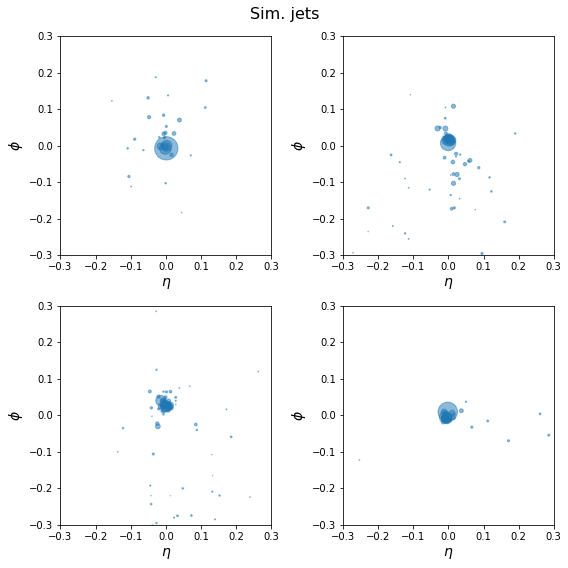

In [32]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    ax.scatter(*particle_data[i, :, :2].T, s=1000 * (particle_data[i, :, 2]), alpha=0.5)
    
    ax.set_xlabel(r"$\eta$", fontsize=14)
    ax.set_ylabel(r"$\phi$", fontsize=14)
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets", fontsize=16)
plt.tight_layout()

/n/home11/smsharma/.local/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


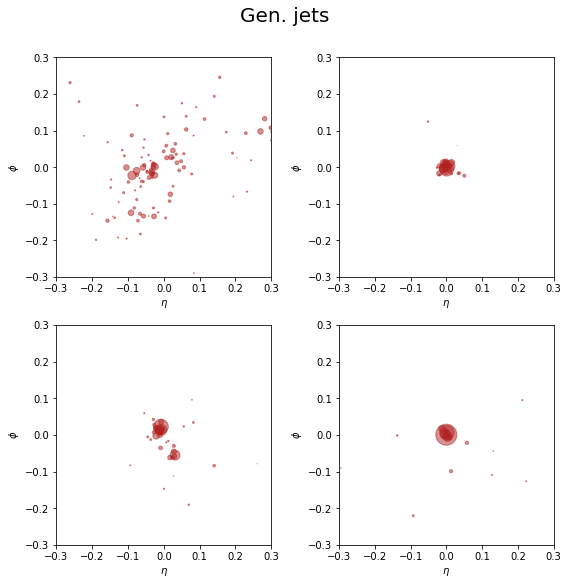

In [33]:
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2)

for i in range(4):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5, color="firebrick")
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

## Evaluate

Compare summaries between genreated and training samples.

In [34]:
# idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)
x = particle_data[idx_rnd] * particle_mask[idx_rnd, :, None]

In [35]:
import energyflow as ef

def jet_masses(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    masses = ef.ms_from_p4s(jets_p4s.sum(axis=1))
    return masses

def jet_ys(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    ys = ef.ys_from_p4s(jets_p4s.sum(axis=1))
    return ys

def jet_etas(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    etas = ef.etas_from_p4s(jets_p4s.sum(axis=1))
    return etas

def jet_phis(jets_ary):
    jets_p4s = ef.p4s_from_ptyphims(jets_ary)
    phis = ef.phis_from_p4s(jets_p4s.sum(axis=1), phi_ref=0)
    return phis

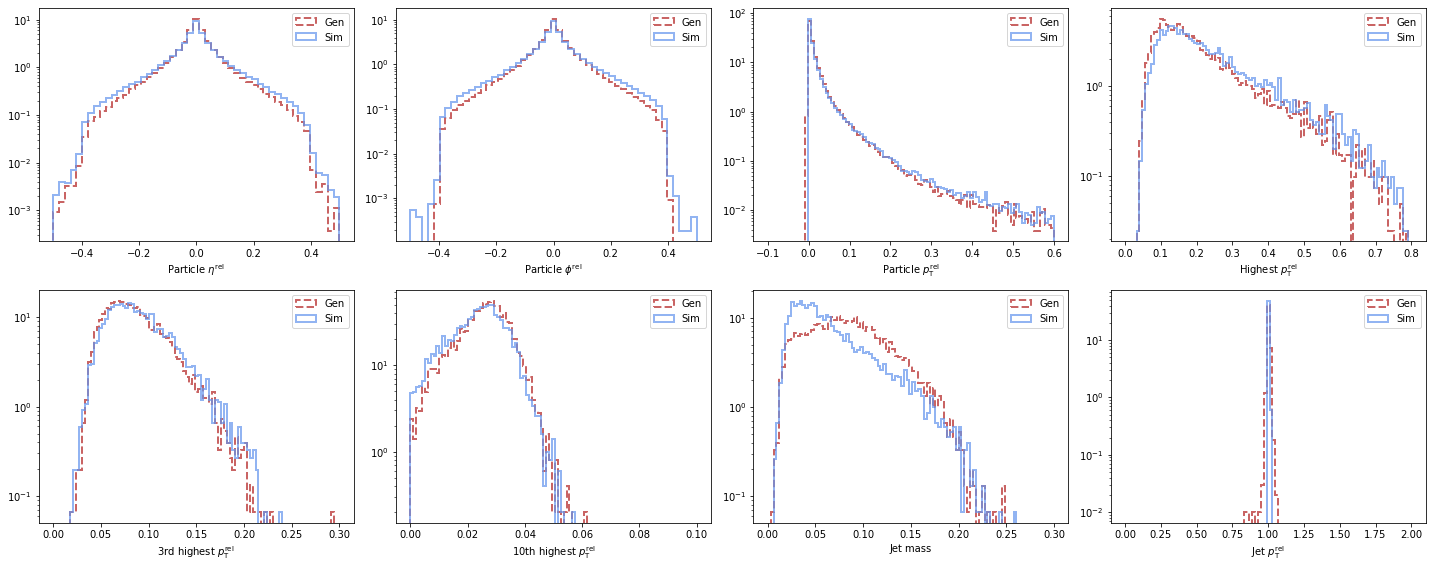

In [36]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

x_samples = np.array(x_samples)
x_samples = x_samples.at[x_samples == 0.].set(-999.)
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.array(np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples = x_samples.at[x_samples == -999].set(0.)
x[x == -999] = 0.

######

ax = fig.add_subplot(gs[3])

bins = np.linspace(0., 0.8, 100)
ax.hist(vnp.array(np.max(x_samples[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.max(x[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = np.linspace(0., 0.3, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = np.linspace(0., 0.1, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= np.linspace(0., 2, 100)

ax.hist(vnp.array(np.abs(x_samples[:, :, 2]).sum(-1)), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.abs(x[:, :, 2]).sum(-1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()

## Just $t$

In [54]:
n_samples = 5000
cond_t = jet_data[jet_data[:, 0] == 2][:n_samples]
mask_t = particle_mask[jet_data[:, 0] == 2][:n_samples]

In [55]:
x_samples_t = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), cond_t, mask=mask_t, steps=500)
x_samples_t = x_samples_t.mean() * mask_t[:, :, None]

In [56]:
x = particle_data[jet_data[:, 0] == 2][:n_samples] * particle_mask[jet_data[:, 0] == 2][:n_samples][:, :, None]

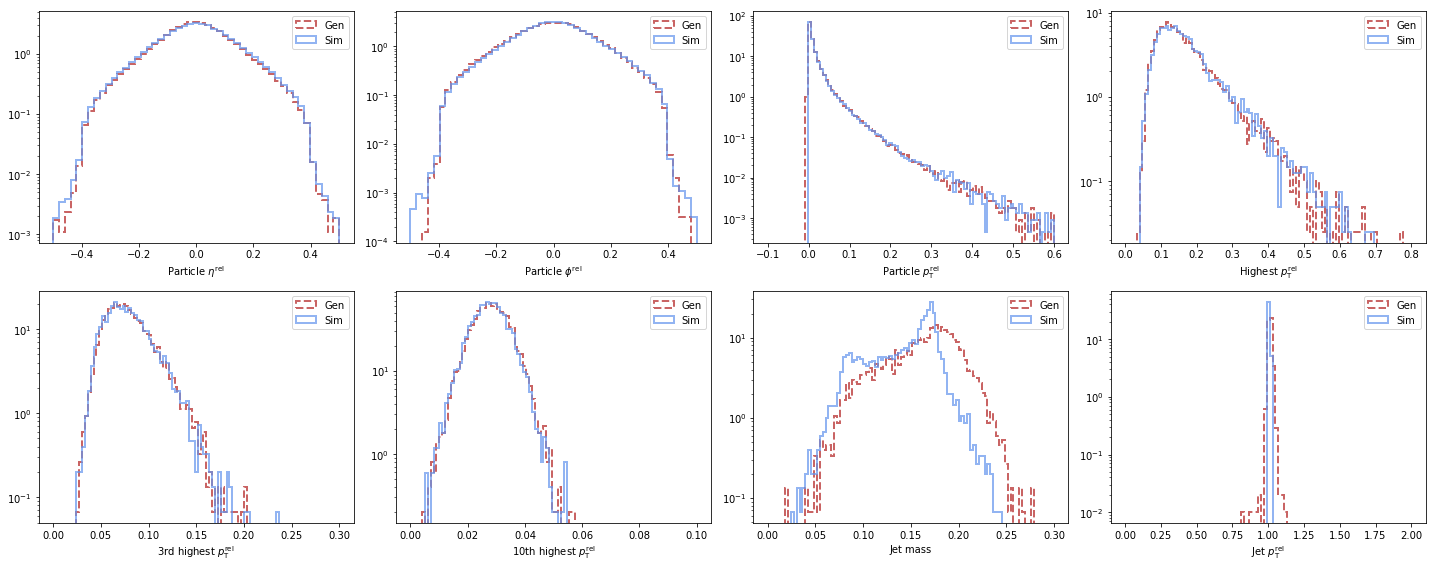

In [57]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

x_samples = np.array(x_samples_t)
x_samples = x_samples.at[x_samples == 0.].set(-999.)
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.array(np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples = x_samples.at[x_samples == -999].set(0.)
x[x == -999] = 0.

######

ax = fig.add_subplot(gs[3])

bins = np.linspace(0., 0.8, 100)
ax.hist(vnp.array(np.max(x_samples[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.max(x[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = np.linspace(0., 0.3, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = np.linspace(0., 0.1, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= np.linspace(0., 2, 100)

ax.hist(vnp.array(np.abs(x_samples[:, :, 2]).sum(-1)), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.abs(x[:, :, 2]).sum(-1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.savefig("plots/t.pdf")

In [58]:
jet_mass_gen = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
jet_mass_sim = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))

In [59]:
from scipy.stats import wasserstein_distance
print('Wasserstein-1 dist. of jet mass: {:.5f}'.format(wasserstein_distance(jet_mass_sim, jet_mass_gen)))

Wasserstein-1 dist. of jet mass: 0.01890


## Just $qg$

In [60]:
n_samples = 5000
cond_qg = jet_data[jet_data[:, 0] != 2][:n_samples]
mask_qg = particle_mask[jet_data[:, 0] != 2][:n_samples]

In [61]:
x_samples_qg = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), cond_qg, mask=mask_qg, steps=1000)
x_samples_qg = x_samples_qg.mean() * mask_qg[:, :, None]

In [62]:
x = particle_data[jet_data[:, 0] != 2][:n_samples] * particle_mask[jet_data[:, 0] != 2][:n_samples][:, :, None]

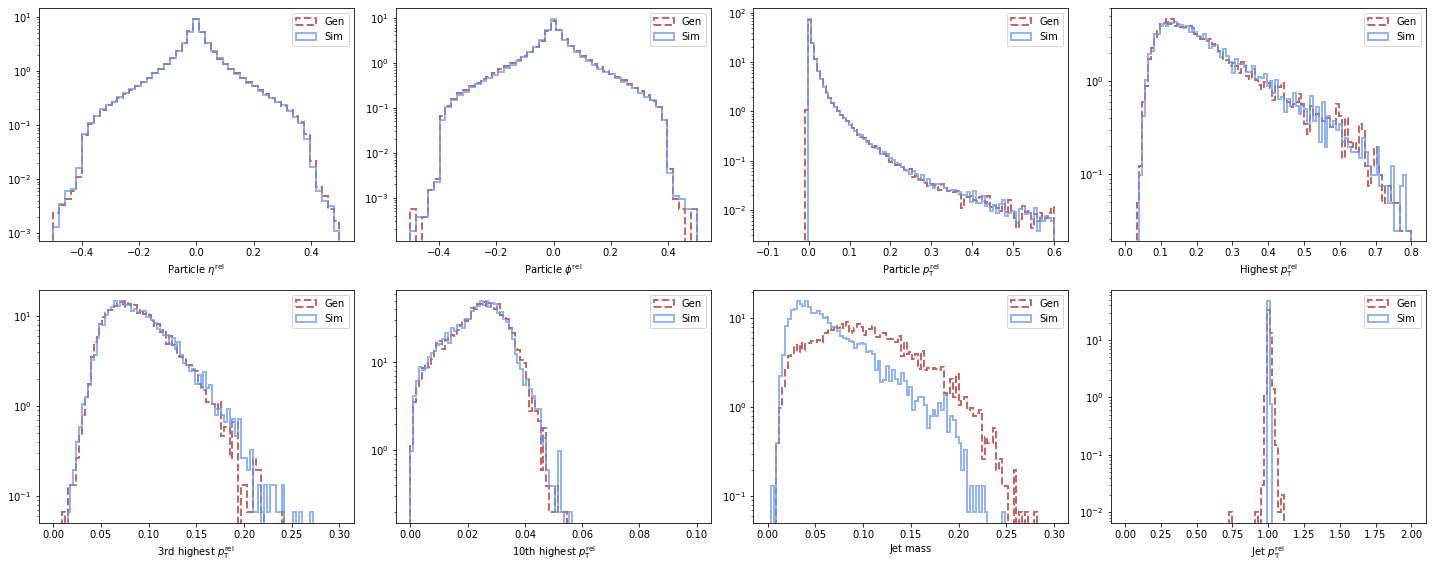

In [63]:
color_sim = "cornflowerblue"
color_gen = "firebrick"

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 4)

x_samples = np.array(x_samples_qg)
x_samples = x_samples.at[x_samples == 0.].set(-999.)
x[x == 0.] = -999.

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = vnp.array(np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")
ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist(vnp.array(np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(vnp.array(eta), histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Particle $p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")
ax.legend()

x_samples = x_samples.at[x_samples == -999].set(0.)
x[x == -999] = 0.

######

ax = fig.add_subplot(gs[3])

bins = np.linspace(0., 0.8, 100)
ax.hist(vnp.array(np.max(x_samples[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.max(x[:, :, 2], -1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[4])

bins = np.linspace(0., 0.3, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -3]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"3rd highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[5])

bins = np.linspace(0., 0.1, 100)
ax.hist(vnp.array(np.sort(x_samples[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.sort(x[:, :, 2])[:, -10]), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"10th highest $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[6])

bins= np.linspace(0., 0.3, 100)

jet_mass = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);

jet_mass = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))
ax.hist(vnp.array(jet_mass), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet mass")
ax.set_yscale("log")
ax.legend()

######

ax = fig.add_subplot(gs[7])

bins= np.linspace(0., 2, 100)

ptsum = vnp.array(np.abs(x_samples[:, :, 2]).sum(-1))

ax.hist(ptsum[ptsum > 0.6], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen', color=color_gen);
ax.hist(vnp.array(np.abs(x[:, :, 2]).sum(-1)), histtype='step', bins=bins, density=True, lw=2, alpha=0.7, label='Sim', color=color_sim);

ax.set_xlabel(r"Jet $p_\mathrm{T}^\mathrm{rel}$")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.savefig("plots/qg.pdf")

In [64]:
jet_mass_gen = jet_masses(np.array([x_samples[:, :, 2], x_samples[:, :, 0], x_samples[:, :, 1]]).transpose(1,2,0))
jet_mass_sim = jet_masses(np.array([x[:, :, 2], x[:, :, 0], x[:, :, 1]]).transpose(1,2,0))

In [65]:
from scipy.stats import wasserstein_distance
print('Wasserstein-1 dist. of jet mass: {:.5f}'.format(wasserstein_distance(jet_mass_sim, jet_mass_gen)))

Wasserstein-1 dist. of jet mass: 0.03423


## Animations

In [105]:
def generate_timestep(vdm, params, rng, shape, timesteps=1000, conditioning=None, mask=None):
    """Generate samples from a VDM model."""

    # Generate latents
    rng, spl = jax.random.split(rng)
    zt = jax.random.normal(spl, shape + (vdm.d_embedding,))

    def body_fn(i, z_t):
        return vdm.apply(params, rng, i, vdm.timesteps, z_t, conditioning, mask=mask, method=vdm.sample_step)

    z0 = jax.lax.fori_loop(lower=0, upper=timesteps, body_fun=body_fn, init_val=zt)

    g0 = vdm.apply(params, 0.0, method=vdm.gammat)
    var0 = sigma2(g0)
    z0_rescaled = z0 / np.sqrt(1.0 - var0)
    return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

In [106]:
timesteps_ary = np.arange(0, 301, 5)

In [124]:
x_samples_timesteps = [generate_timestep(vdm, restored_state.params, rng, (1, 100), timesteps=t, conditioning=np.array([2., 0., 0., 0.])[None, :], mask=np.ones((1, 100))) for t in tqdm(timesteps_ary)]
x_samples_timesteps = np.array([xx.mean()[0] for xx in x_samples_timesteps])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [02:58<00:00,  2.92s/it]


/n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


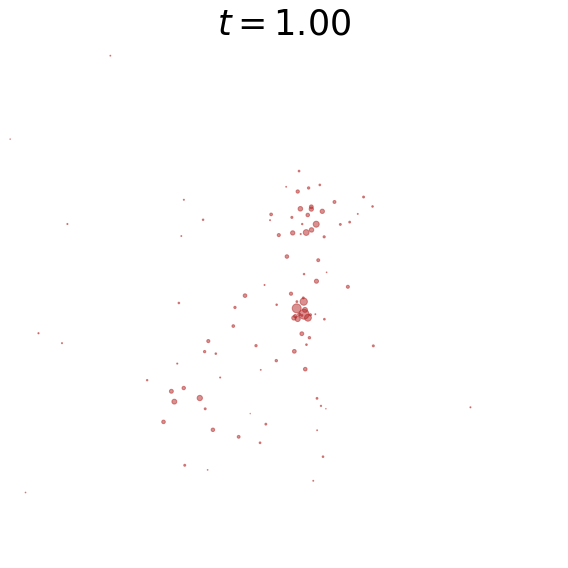

In [125]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib

fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(1, 1, 1)

def update(frame):
    
    ax2.clear()
        
    x_plot = x_samples_timesteps[frame] * x_std + x_mean

    ax2.scatter(*x_plot[:, :2].T, s=1000 * (x_plot[:, 2]), alpha=0.5, color='firebrick')
    
    ax2.set_xlabel(r"$\eta$", fontsize=14)
    ax2.set_ylabel(r"$\phi$", fontsize=14)
    
    ax2.set_xlim(-0.3, 0.3)
    ax2.set_ylim(-0.3, 0.3)
    
    ax2.set_title(r"$t = {:.2f}$".format(round(timesteps_ary[frame] / vdm.timesteps, 2)), fontsize=35)
    
    ax2.set_axis_off()
    
    plt.tight_layout()

ani = animation.FuncAnimation(fig, update, frames=len(x_samples_timesteps), interval=100)
ani.save("plots/animation_diffusion_jets_t.gif", writer="imagemagick")

In [162]:
rng = jax.random.PRNGKey(142)

n_samples = 8

q_jet = generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[0., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100)))
g_jet = generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[1., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100)))
t_jet = generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[2., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100)))

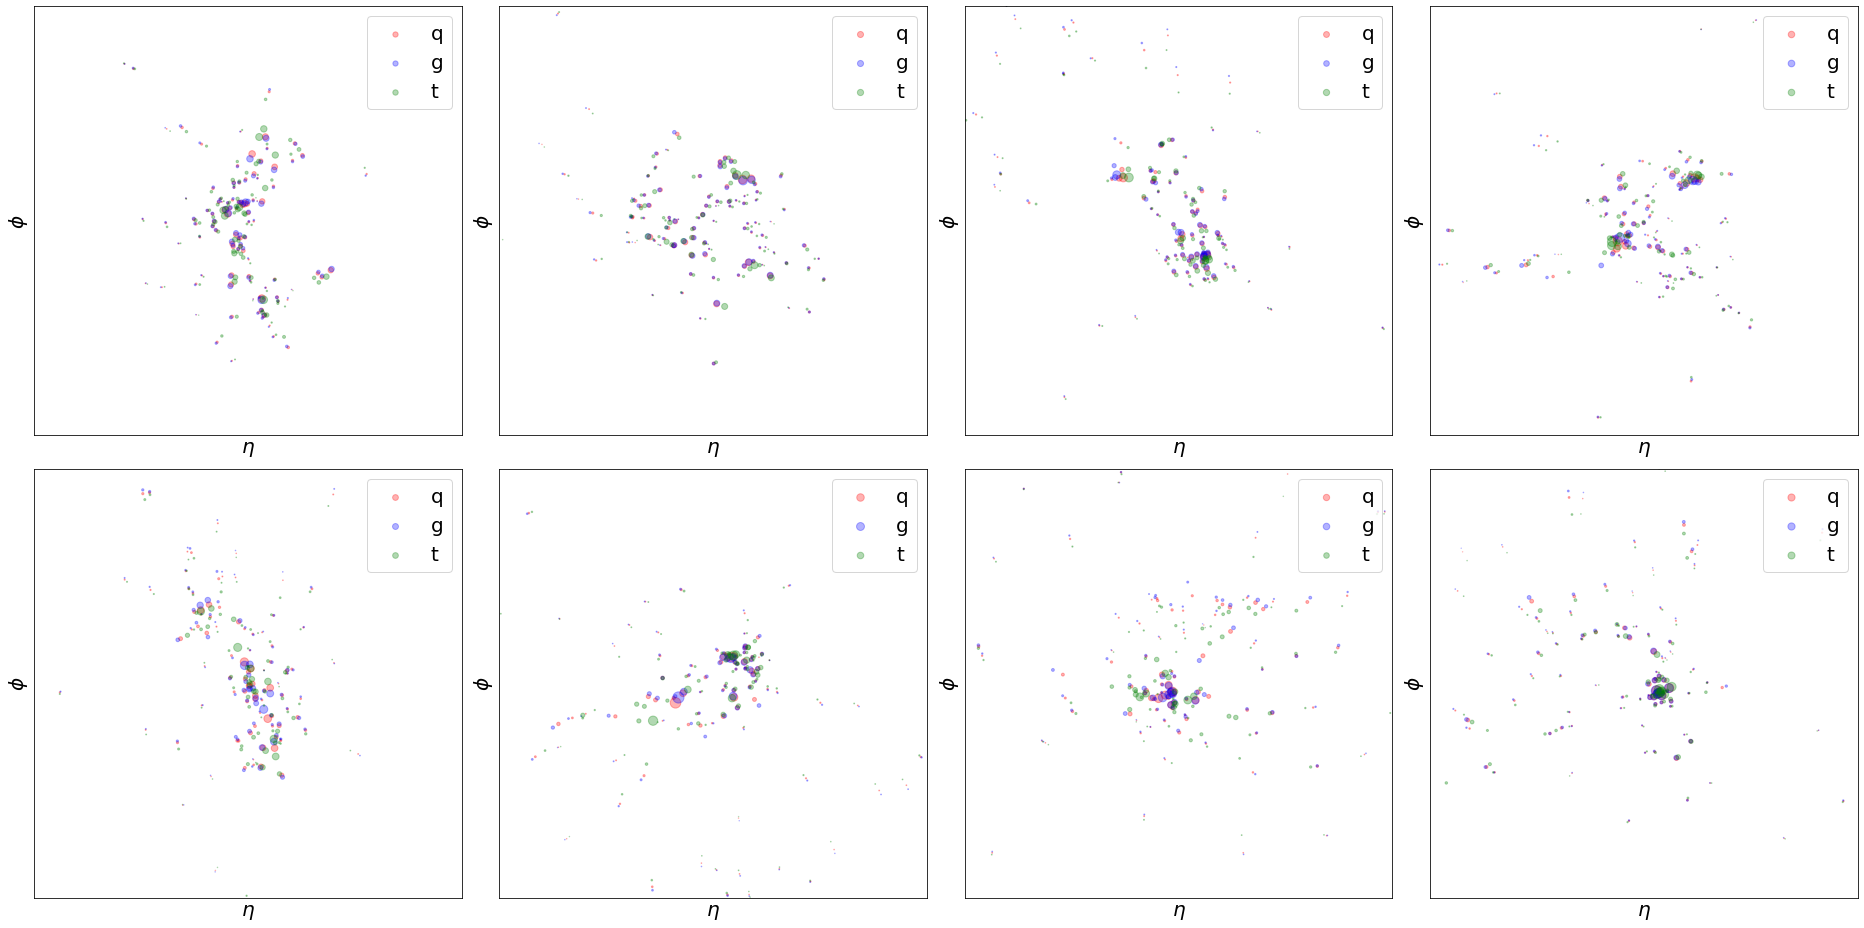

In [173]:
fig = plt.figure(figsize=(26, 13))
gs = GridSpec(2, 4)


colors = ['red', 'blue', 'green']
labels = ["q", "g", "t"]

for i in range(8):
    
    ax = fig.add_subplot(gs[i])

    for j, jet in enumerate([q_jet.mean(), g_jet.mean(), t_jet.mean()]):

        x_plot = jet[i] * x_std + x_mean

        ax.scatter(*x_plot[:, :2].T, s=1000 * (x_plot[:, 2]), alpha=0.3, color=colors[j], label=labels[j])

        ax.set_xlabel(r"$\eta$", fontsize=20)
        ax.set_ylabel(r"$\phi$", fontsize=20)

        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)

        ax.set_yticklabels([])
        ax.set_xticklabels([])

        ax.set_xticks([])
        ax.set_yticks([])

        ax.legend(loc='upper right', fontsize=20)

        plt.tight_layout()

In [174]:
timesteps_ary = np.arange(0, 301, 10)

In [175]:
rng = jax.random.PRNGKey(142)

n_samples = 8

q_jets = [generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=timesteps, conditioning=np.repeat(np.array([[0., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100))) for timesteps in tqdm(timesteps_ary)]
g_jets = [generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=timesteps, conditioning=np.repeat(np.array([[1., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100))) for timesteps in tqdm(timesteps_ary)]
t_jets = [generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=timesteps, conditioning=np.repeat(np.array([[2., 0., 0., 0.]]), n_samples, 0), mask=np.ones((n_samples, 100))) for timesteps in tqdm(timesteps_ary)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:30<00:00,  2.93s/it]


In [176]:
q_jets = np.array([xx.mean() for xx in q_jets])
g_jets = np.array([xx.mean() for xx in g_jets])
t_jets = np.array([xx.mean() for xx in t_jets])

In [223]:
colors = ['firebrick', 'navy', 'forestgreen']

In [224]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='$q$ jets',
                          markerfacecolor=colors[0], markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$g$ jets',
                          markerfacecolor=colors[1], markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$t$ jets',
                          markerfacecolor=colors[2], markersize=8)]

/n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


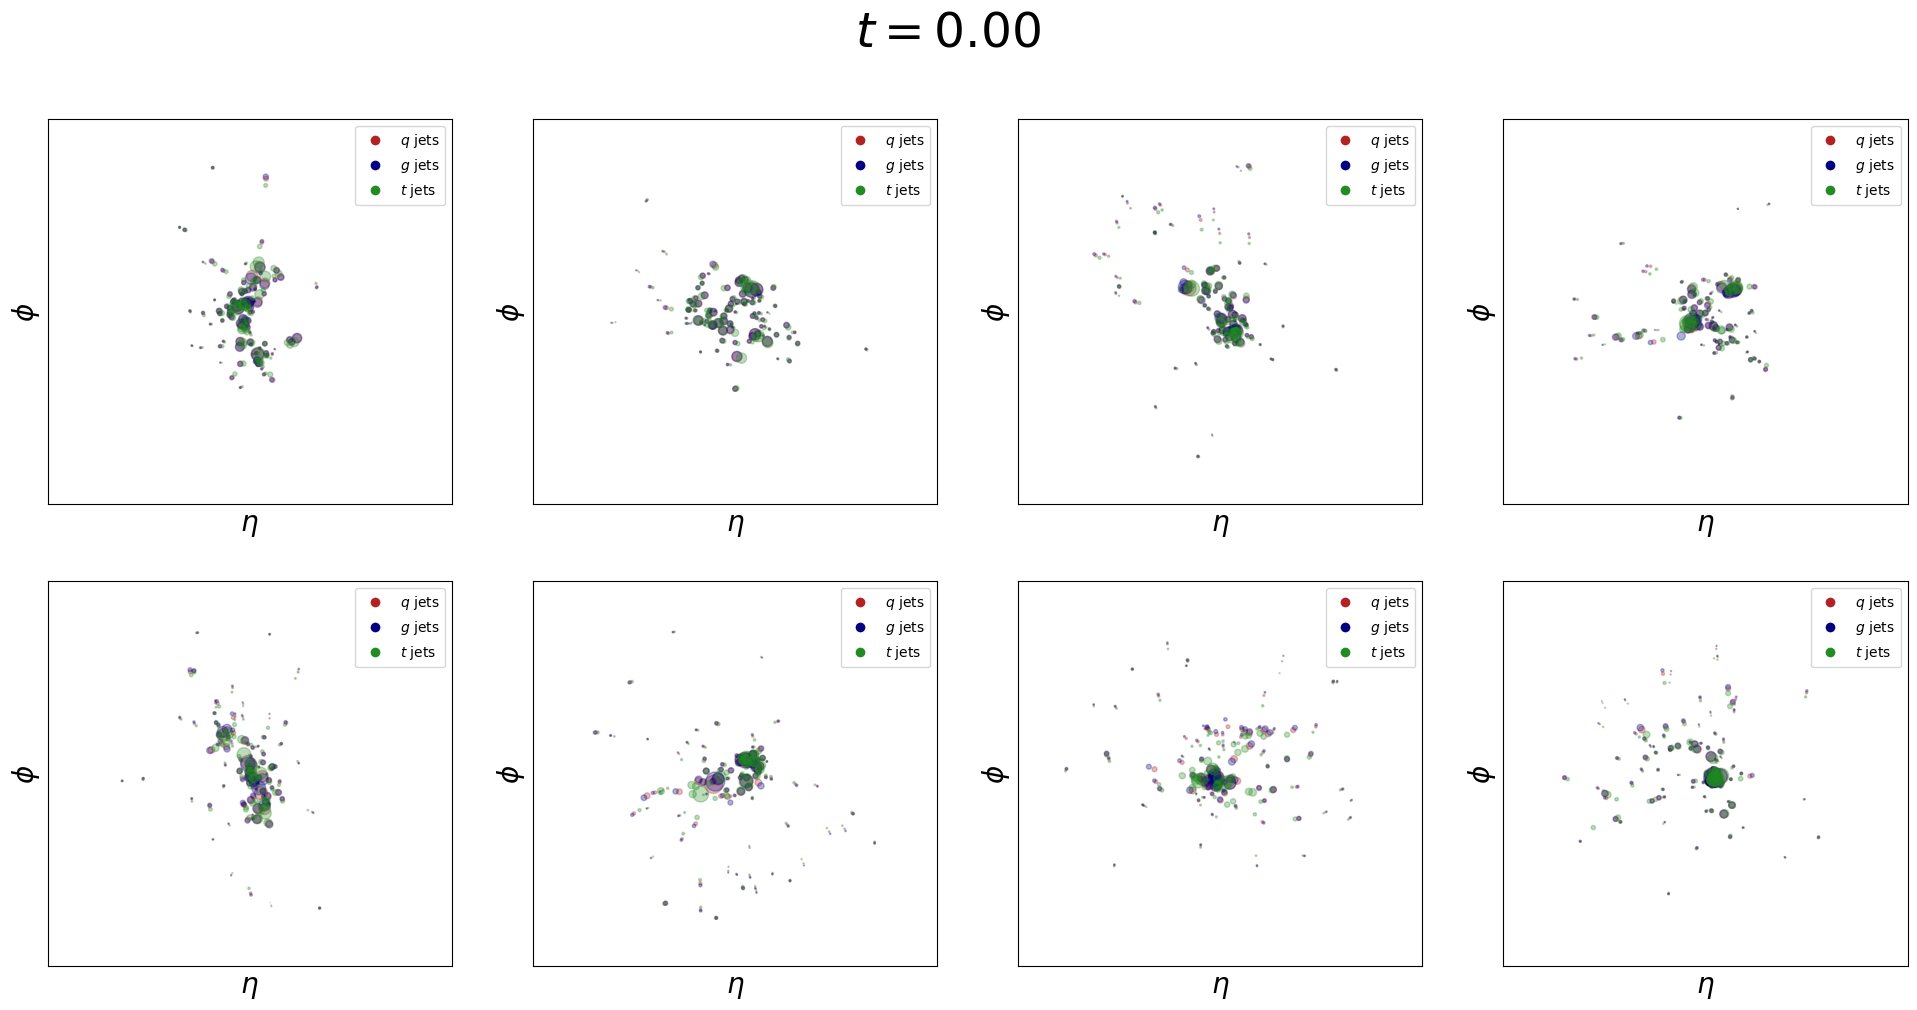

In [250]:
plt.style.use('default')

fig = plt.figure(figsize=(24, 11))

gs = GridSpec(2, 4)

ax = []
for i in range(8):
    ax.append(fig.add_subplot(gs[i]))

def update(frame):
    
    for i in range(8):
        ax[i].clear()
    
    for i in range(8):

        for j, jet in enumerate([q_jets[frame], g_jets[frame], t_jets[frame]]):

            x_plot = jet[i] * x_std + x_mean
            
            ax[i].scatter(*x_plot[:, :2].T, s=1500 * (x_plot[:, 2]), alpha=0.3, color=colors[j], label=labels[j])

            ax[i].set_xlabel(r"$\eta$", fontsize=20)
            ax[i].set_ylabel(r"$\phi$", fontsize=20)

            ax[i].set_xlim(-0.5, 0.5)
            ax[i].set_ylim(-0.5, 0.5)

            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])

            ax[i].set_xticks([])
            ax[i].set_yticks([])
            
            ax[i].legend(handles=legend_elements, loc='upper right')
            
            plt.suptitle(r"$t = {:.2f}$".format(round(1. - timesteps_ary[frame] / vdm.timesteps, 2)), fontsize=35)
            
ani = animation.FuncAnimation(fig, update, frames=q_jets.shape[0], interval=100)
ani.save("plots/animation_diffusion_jets.gif", writer="imagemagick")

In [236]:
jet_mass_ary = np.linspace(0, 6, len(timesteps_ary))

In [238]:
rng = jax.random.PRNGKey(142)
n_samples = 8

q_jets_mass, g_jets_mass, t_jets_mass = [], [], []
for i in range(len(timesteps_ary)):
    q_jets_mass.append(generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[0., 0., 0., jet_mass_ary[i]]]), n_samples, 0), mask=np.ones((n_samples, 100))).mean()) 
    g_jets_mass.append(generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[1., 0., 0., jet_mass_ary[i]]]), n_samples, 0), mask=np.ones((n_samples, 100))).mean())
    t_jets_mass.append(generate_timestep(vdm, restored_state.params, rng, (n_samples, 100), timesteps=300, conditioning=np.repeat(np.array([[2., 0., 0., jet_mass_ary[i]]]), n_samples, 0), mask=np.ones((n_samples, 100))).mean())

In [241]:
q_jets_mass = np.array(q_jets_mass)
g_jets_mass = np.array(g_jets_mass)
t_jets_mass = np.array(t_jets_mass)

/n/sw/eb/apps/centos7/Anaconda3/2022.05/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


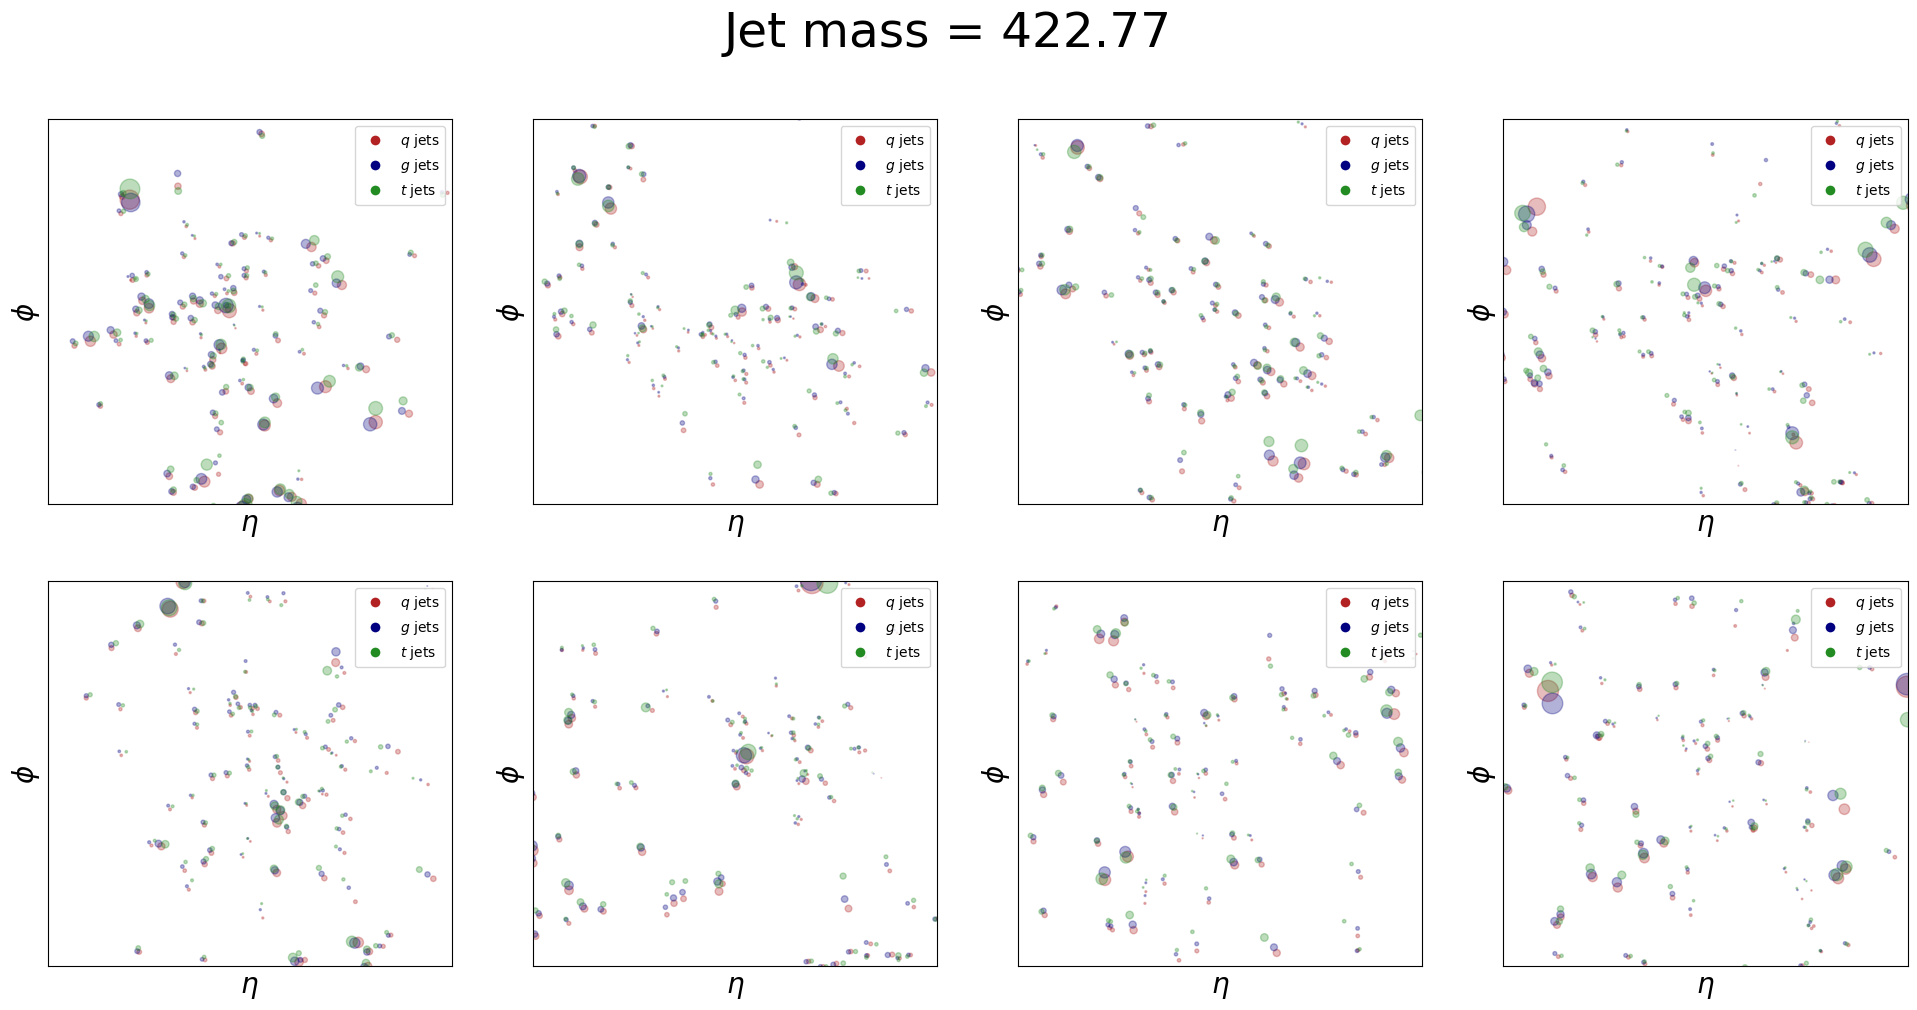

In [276]:
plt.style.use('default')

fig = plt.figure(figsize=(24, 11))

gs = GridSpec(2, 4)

ax = []
for i in range(8):
    ax.append(fig.add_subplot(gs[i]))

def update(frame):
    
    for i in range(8):
        ax[i].clear()
    
    for i in range(8):

        for j, jet in enumerate([q_jets_mass[frame], g_jets_mass[frame], t_jets_mass[frame]]):

            x_plot = jet[i] * x_std + x_mean
            
            ax[i].scatter(*x_plot[:, :2].T, s=1500 * (x_plot[:, 2]), alpha=0.3, color=colors[j], label=labels[j])

            ax[i].set_xlabel(r"$\eta$", fontsize=20)
            ax[i].set_ylabel(r"$\phi$", fontsize=20)

            ax[i].set_xlim(-0.5, 0.5)
            ax[i].set_ylim(-0.5, 0.5)

            ax[i].set_yticklabels([])
            ax[i].set_xticklabels([])

            ax[i].set_xticks([])
            ax[i].set_yticks([])
            
            ax[i].legend(handles=legend_elements, loc='upper right')
            
            plt.suptitle(r"Jet mass = {:.2f}".format(round(jet_mass_ary[frame] * jet_data_std[-2] + jet_data_mean[-2], 2)), fontsize=35)
            
ani = animation.FuncAnimation(fig, update, frames=q_jets.shape[0], interval=100)
ani.save("plots/animation_diffusion_jets_mass.gif", writer="imagemagick")